In [17]:
import torch
import torchvision.transforms.functional as F

from PIL import Image

import pandas as pd

import numpy as np

import pickle

import os

from tqdm import tqdm

from models import UNet

In [2]:
label_frame = pd.read_csv("../data/label_frame.csv")
label_frame.head()

,file,"forehead (0, 1, 2)","length (0, 1, 2, 3, 4)"
0,0.jpg,2,NaN
1,1.jpg,2,NaN
2,2.jpg,2,NaN
3,3.jpg,2,NaN
4,4.jpg,2,NaN


In [3]:
label_frame = label_frame.to_numpy().tolist()
print(label_frame[:3])

[['0.jpg', '2', nan], ['1.jpg', '2', nan], ['2.jpg', '2', nan]]


In [5]:
with open("../data/male_path_to_celeba_path.pickle", "rb") as f:
    male_path_to_celeba_path = pickle.load(f)

In [8]:
model = UNet().to("cuda")
model.eval()
model.load_state_dict(torch.load("./best_params.pth"))

<All keys matched successfully>

In [20]:
latent_codes = {
    "0": [], # (이마 다 보임)
    "1": [] # (이마 가림)
}

In [21]:
for male_path, forehead, length in tqdm(label_frame):
    img = Image.open(os.path.join("../data", "male", male_path)).convert("RGB").resize((256, 256))
    img = F.to_tensor(img).to("cuda").unsqueeze(0)

    latent_code = img

    for i in range(len(model.encoder)):
        latent_code = model.encoder[i](latent_code)

    latent_code = model.center[0](latent_code)

    if type(forehead) != float and not pd.isnull(forehead):
        if forehead in ["1", "2"]:
            latent_codes["1"].append((male_path, latent_code.squeeze(0).view(-1).cpu().detach()))

        elif forehead == "0":
            latent_codes["0"].append((male_path, latent_code.squeeze(0).view(-1).cpu().detach()))

100%|██████████| 7443/7443 [00:37<00:00, 200.89it/s]


In [22]:
len(latent_codes["0"]), len(latent_codes["1"])

(90, 537)

In [24]:
latent_codes_tensor = torch.stack((*[code[1] for code in latent_codes["0"]], *[code[1] for code in latent_codes["1"]]), dim=0)
latent_codes_tensor.shape

torch.Size([627, 8192])

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(latent_codes_tensor.numpy())

StandardScaler()

In [26]:
scaled_codes = scaler.transform(latent_codes_tensor.numpy())
print(scaled_codes.shape)

(627, 8192)


In [27]:
scaled_codes[0]

array([ 0.7143237 , -0.15393415, -1.0422374 , ..., -0.43113112,
       -0.7688767 , -0.0419018 ], dtype=float32)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(scaled_codes)

decomposed_codes = pca.transform(scaled_codes)

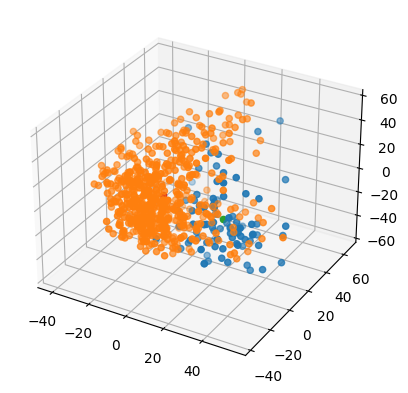

In [53]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection="3d")
ax.scatter(decomposed_codes[:90, 2], decomposed_codes[:90, 1], decomposed_codes[:90, 0], label="forehead 0")
ax.scatter(decomposed_codes[90:, 2], decomposed_codes[90:, 1], decomposed_codes[90:, 0], label="forehead 1, 2")
ax.scatter(decomposed_codes[:90, 2].mean(), decomposed_codes[:90, 1].mean(), decomposed_codes[:90, 0].mean(), label="forehead 0 proto")
ax.scatter(decomposed_codes[90:, 2].mean(), decomposed_codes[90:, 1].mean(), decomposed_codes[90:, 0].mean(), label="forehead 1, 2 proto")

In [68]:
proto0 = torch.mean(latent_codes_tensor[:90], dim=0)
proto1 = torch.mean(latent_codes_tensor[90:], dim=0)

pred = torch.zeros((627, 1))
print(proto0.shape, proto1.shape, pred.shape)

torch.Size([8192]) torch.Size([8192]) torch.Size([627, 1])


In [74]:
dis0 = ((latent_codes_tensor - proto0)**2).sum(dim=1)
dis1 = ((latent_codes_tensor - proto1)**2).sum(dim=1)

print(dis0.shape, dis1.shape)

torch.Size([627]) torch.Size([627])


In [80]:
pred = (dis0 > dis1).type(torch.long) # 0: forehead 0, 1: forehead 1
print((pred[:90] == 0).sum())
print((pred[90:] == 1).sum())

tensor(83)
tensor(488)


In [81]:
print(((pred[:90] == 0).sum() + (pred[90:] == 1).sum()) / len(pred))

tensor(0.9107)


In [83]:
(pred == 0).sum(), (pred == 1).sum()

(tensor(132), tensor(495))

In [86]:
torch.abs(dis0 - dis1)[:90]

tensor([180.0000, 360.0881, 342.2076, 491.8374, 205.1342, 633.8329, 194.6173,
        641.6785,  75.7034, 100.6572, 540.3330, 153.1700, 262.0974, 287.6376,
        230.7336, 546.7488, 552.7570, 842.8419, 223.0017, 518.4751, 157.7877,
         70.2152, 484.2432, 327.3926, 101.8634,  16.8806, 456.6034, 136.4780,
        439.1802, 173.1013,  43.8245, 423.7970, 681.6930, 503.1621, 619.5375,
        698.3877, 458.3345,  81.0503, 408.3824, 549.0151, 318.9574, 199.3586,
        358.3337, 433.5254, 647.3900, 147.7053, 731.6560, 907.4895, 372.9343,
        175.3480, 217.2432, 583.8569, 493.3823, 123.7740, 337.6151, 643.1664,
        671.3237, 302.8928, 931.6215, 666.9994, 468.3702, 141.8389, 459.5605,
        438.5698,   5.7808, 295.7115,  40.9573, 975.2971, 760.5004, 574.3135,
         49.7479, 444.3235, 609.4784, 480.8312, 457.9495, 636.9700, 628.8164,
        154.2848, 572.4445, 720.5408, 391.8994,  69.4486, 265.6392, 503.4779,
        415.0607, 277.3058, 435.9518, 486.1069, 269.1320, 716.35

In [94]:
torch.abs(dis0 - dis1)[:90][pred[:90] == 1].mean(), torch.abs(dis0 - dis1)[:90].mean()

(tensor(121.0682), tensor(402.5079))

In [95]:
torch.abs(dis0 - dis1)[90:][pred[90:] == 0].mean(), torch.abs(dis0 - dis1)[90:].mean()

(tensor(193.2068), tensor(418.9345))